# Data setup

In [1]:
import re

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt

import scipy as sp
import seaborn as sns

import sys
sys.path.append('..')
import src.data.util as du
import src.text.tokenizer as tk

d90_file = '../results/complexity_utf-16_1010_10_10_bibles_90_lcm.csv'
dall_file = '../results/complexity_utf-16_2020_10_10_bibles_lcm.csv'
family_file = '../dataset/family.csv'

bible_file_d90 = '../dataset/' + re.match('.*(bibles_.*)', d90_file).group(1)
bibles_d90 = pd.read_csv(bible_file_d90, index_col=False)
bibles_d90 = bibles_d90[bibles_d90.language != 'NAMBIKUÁRA']

df90 = pd.read_csv(d90_file, index_col=False)
df90 = df90[df90.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
df90.loc[df90.metric == 'del-chars', 'value'] = - df90.loc[df90.metric == 'del-chars', 'value']
df90.loc[df90.metric == 'rep-words', 'value'] = 1/df90.loc[df90.metric == 'rep-words', 'value']

bible_file_dall = '../dataset/' + re.match('.*(bibles_.*)', dall_file).group(1)
bibles_dall = pd.read_csv(bible_file_dall, index_col=False)
bibles_dall = bibles_dall[bibles_dall.language != 'NAMBIKUÁRA']

dfall = pd.read_csv(dall_file, index_col=False)
dfall = dfall[dfall.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
dfall.loc[dfall.metric == 'del-chars', 'value'] = - dfall.loc[dfall.metric == 'del-chars', 'value']
dfall.loc[dfall.metric == 'rep-words', 'value'] = 1/dfall.loc[dfall.metric == 'rep-words', 'value']

family = pd.read_csv(family_file, index_col=None)

dfall = dfall.drop(columns=['language']).merge(
    family.drop(
        columns=['countries', 'branch']
    ), on='wals', how='inner').rename(columns={ 'wals' : 'code'})
df90 = df90.drop(columns=['language']).merge(
    family.drop(
        columns=['countries', 'branch'])
    , on='wals', how='inner').rename(columns={ 'wals' : 'code'})

metric_rename = {'del-chars'  : r'morphological deletion',
                 'del-verses' : r'pragmatic deletion',
                 'del-words'  : r'syntactic deletion',
                 'rep-words'  : r'morphological substitution',
                 'do-nothing' : r'size'
                }

dfall = dfall.replace(metric_rename)
df90 = df90.replace(metric_rename)


rall = dfall.groupby(
    by=['language', 'family', 'code', 'metric', 'algorithm'],
    as_index=False).agg({'value' : ['mean', 'var']})
r90 = df90.groupby(
    by=['language', 'family', 'code', 'metric', 'algorithm'],
    as_index=False).agg({'value' : ['mean', 'var']})

# Helper functions

In [2]:
def compute_numtypes_numtokens(df):
    langs = du.by_field(df, 'language')
    united = {
        lang : du.df_to_str(val)
        for lang, val in langs.items()
    }

    d = dict(language=[], tokens=[], types=[])
    for lang, text in united.items():
        d['language'].append(lang)
        tokens = tk.tokens(text)
        d['tokens'].append(len(tokens))
        d['types'].append(len(tk.types(tokens)))
    return d


def compute_num_chars(df):
    from collections import Counter
    d = dict(language=[], chars=[])
    for lang in set(df.language):
        c = Counter('\n'.join(df[df.language == lang].text))
        d['language'].append(lang)
        d['chars'].append(len(c))
    dd = pd.DataFrame(d)
    return dd


def num_chars_across_bible(df, bibles):
    nc = compute_num_chars(bibles).sort_values('language').reset_index().drop(columns='index').chars.to_numpy()
    out = h1(df)
    for algo, (dfs, _, __) in out.items():
        if algo == 'none': continue
        y = dfs.drop_duplicates('language').sort_values('language').reset_index().drop(columns='index').oc.to_numpy()
        r = sp.stats.pearsonr(nc, y)
        print("%6s statistic: %.5f pvalue: %.5f" % (algo, r.statistic, r.pvalue))

# H1 Overall complexity of a text

The overall complexity of a text in its
original language is lower than in the other
languages, as a result of the introduction
of cultural clarification in the translation process.
The language complexity of a translated text should be greater than their counterpart in the source language.

In [3]:
def h1(df):
    unique_algorithms = list(df.algorithm.unique())
    out = {}
    for algorithm in unique_algorithms:
        ag = df.algorithm == algorithm
        nn = df.algorithm == 'none'
        sz = df.metric == 'size'
        rw = df[sz & nn]
        co = df[sz & ag]

        x = rw.sort_values('language').value.to_numpy()
        y = co.sort_values('language').value.to_numpy()
        lr = sp.stats.linregress(x, y)
        ỹ = lr.slope*x + lr.intercept
        oc = y - ỹ
        out[algorithm] = (
            pd.DataFrame(dict(language=list(rw.sort_values('language').language),
                              oc=oc, rw=x, co=y)),
            x,
            ỹ                 
        )
    return out

def plth1(df, title=None):
    out = h1(df)
    fig, ax = plt.subplots(1, len(out), figsize=(5*len(out), 5))

    for i, (algo, (dfr, x, ỹ)) in enumerate(out.items()):
        ax[i].plot(x, ỹ)
        ax[i].scatter(x='rw', y='co', data=dfr)
        ax[i].set_title(fr'$\it{{{algo}}}$')
        ax[i].set_xlabel('size in bytes')
        ax[i].set_ylabel('size in bytes compressed')

    if title:
        fig.suptitle(title)
    fig.tight_layout()

## D90 Subset

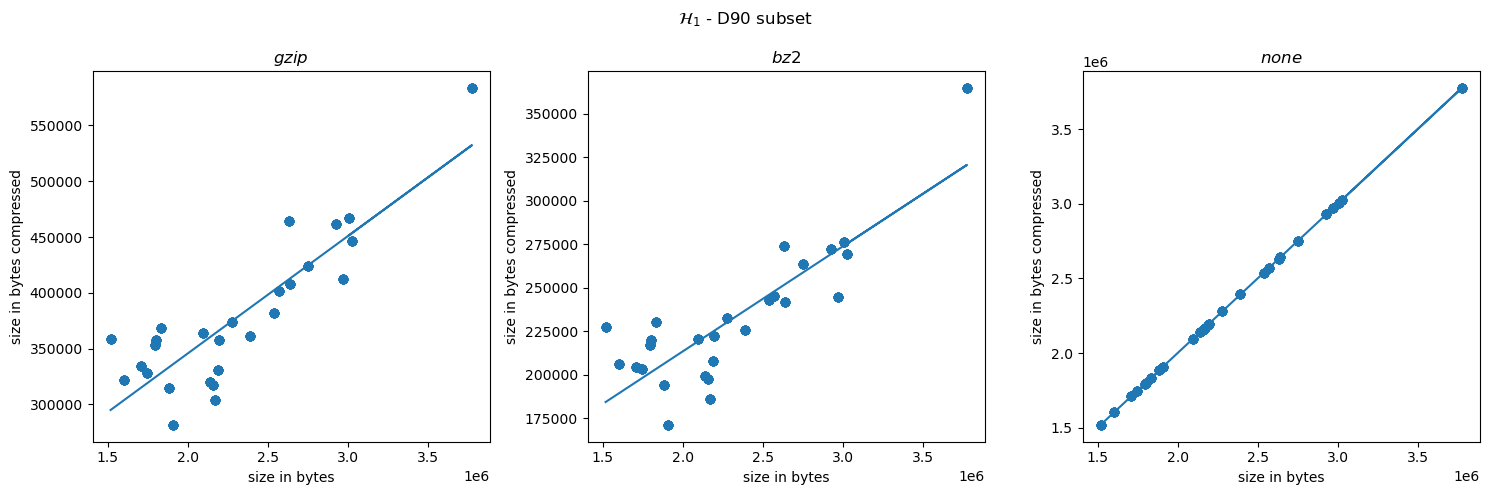

In [4]:
out90 = h1(df90)
plth1(df90, title=r"$\mathcal{H}_1$ - D90 subset")

In [5]:
num_chars_across_bible(df90, bibles_d90)

  gzip statistic: 0.44811 pvalue: 0.01907
   bz2 statistic: 0.42947 pvalue: 0.02538


In [6]:
l = 'Sateré-Mawé'
num_chars_across_bible(df90[df90.language != l], bibles_d90[bibles_d90.language != l.upper()])

  gzip statistic: 0.51575 pvalue: 0.00700
   bz2 statistic: 0.53862 pvalue: 0.00453


## DALL Subset

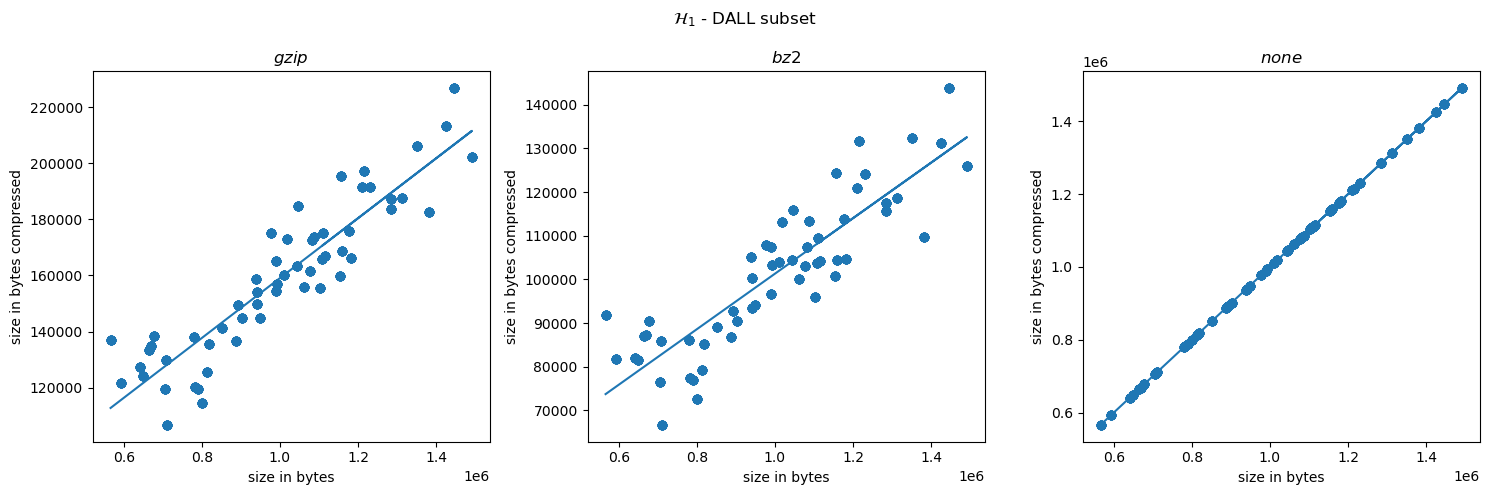

In [7]:
outall = h1(dfall)
plth1(dfall, title=r"$\mathcal{H}_1$ - DALL subset")

In [8]:
num_chars_across_bible(dfall, bibles_dall)

  gzip statistic: 0.39055 pvalue: 0.00292
   bz2 statistic: 0.39292 pvalue: 0.00274


In [9]:
l = 'Sateré-Mawé'
num_chars_across_bible(dfall[dfall.language != l], bibles_dall[bibles_dall.language != l.upper()])

  gzip statistic: 0.44913 pvalue: 0.00058
   bz2 statistic: 0.44878 pvalue: 0.00059


# H2 Content invariance
For any complexity measure, Bible complexity should be the same (independenlty of translation).
In this case, we should observe a smaller variance in size in bytes of the compressed texts in comparison with
the uncompressed texts.

In [10]:
def h2(rdf):
    H2 = rdf.groupby(by=['metric', 'algorithm'],
                     as_index=False).agg({('value', 'mean') : ['mean', 'var']})

    for algorithm in ['gzip', 'bz2']:
        x = np.log10(
            H2[(H2.metric == 'size') \
            & (H2.algorithm == algorithm)][('value', 'mean', 'var')].item()
        )
        y = np.log10(
            H2[(H2.metric == 'size') \
            & (H2.algorithm == 'none')][('value', 'mean', 'var')].item()
        )
        print('%-4s variance has %d decimal places\n\tOriginal size variance has %d decimal places' \
              % (algorithm, int(np.ceil(x)), int(np.ceil(y))))

def ploth2(outdf, text):
    fig, ax = plt.subplots()
    fig.suptitle(f"Overall Complexity Distribution through the Evaluated Languages for {text} Subset")
    ax.hist(x='oc', bins=10, data=outdf['gzip'][0], label='gzip')
    ax.hist(x='oc', bins=10, data=outdf['bz2'][0], label='bz2')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Count')
    ax.legend()

## D90 Subset

In [11]:
h2(r90)

gzip variance has 10 decimal places
	Original size variance has 12 decimal places
bz2  variance has 10 decimal places
	Original size variance has 12 decimal places


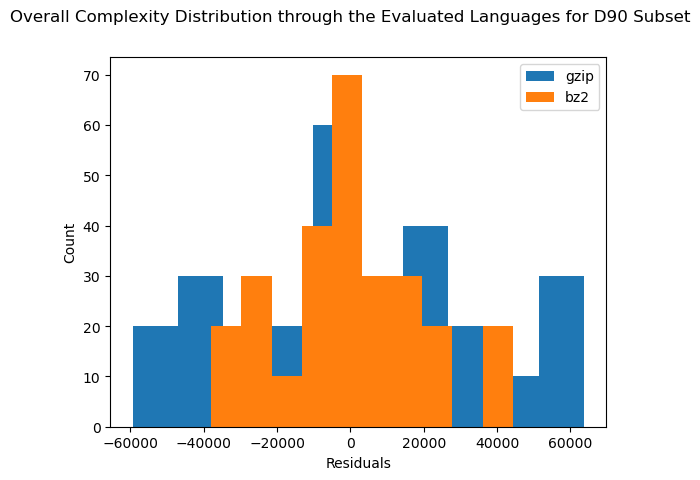

In [12]:
ploth2(out90, "D90")

## DALL Subset

In [13]:
h2(rall)

gzip variance has 9 decimal places
	Original size variance has 11 decimal places
bz2  variance has 9 decimal places
	Original size variance has 11 decimal places


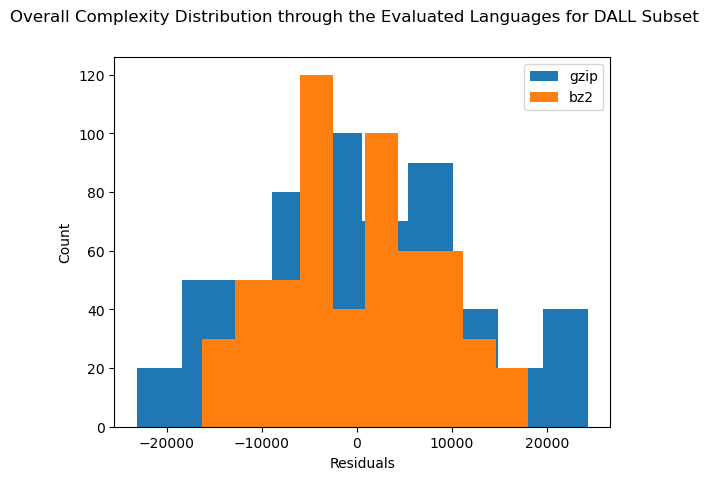

In [14]:
ploth2(outall, "DALL")

# H3 Morphology and Syntatic trade-off
Languages that have a higher morphological complexity show a smaller syntatic complexity and vice-versa.

In [15]:
def h3(df):
    metrics = ['morphological deletion', 'syntactic deletion']
    algorithms = ['gzip', 'bz2']

    for i, algorithm in enumerate(algorithms):
        print('Algorithm %6s' % algorithm)
        a = df.algorithm == algorithm
        xs = [df[(df.metric == metric) & a][('value', 'mean')] for metric in metrics]
        cr =  sp.stats.pearsonr(xs[0], xs[1])
        print('\tPearson Correlation: statistic: %.4f p-value: %.4f' % (cr.statistic, cr.pvalue))

## D90 Subset

In [16]:
print('All languages')
h3(r90)

indo_european_languages = ("Ancient Greek", "English", "French", "Germany", "Portuguese", "Spanish")

r90_iel = r90[r90.language.isin(indo_european_languages)]

print('\nOnly Indo-European Languages')
h3(r90_iel)

All languages
Algorithm   gzip
	Pearson Correlation: statistic: -0.3434 p-value: 0.0795
Algorithm    bz2
	Pearson Correlation: statistic: -0.1966 p-value: 0.3256

Only Indo-European Languages
Algorithm   gzip
	Pearson Correlation: statistic: -0.8573 p-value: 0.0291
Algorithm    bz2
	Pearson Correlation: statistic: -0.9232 p-value: 0.0086


## DALL Subset

In [17]:
print('All languages')
h3(rall)

indo_european_languages = ("Ancient Greek", "English", "French", "Germany", "Portuguese", "Spanish")

rall_iel = rall[rall.language.isin(indo_european_languages)]

print('\nOnly Indo-European Languages')
h3(r90_iel)

All languages
Algorithm   gzip
	Pearson Correlation: statistic: -0.4542 p-value: 0.0004
Algorithm    bz2
	Pearson Correlation: statistic: -0.4713 p-value: 0.0002

Only Indo-European Languages
Algorithm   gzip
	Pearson Correlation: statistic: -0.8573 p-value: 0.0291
Algorithm    bz2
	Pearson Correlation: statistic: -0.9232 p-value: 0.0086


# O1 Morphological Complexity, tokens and types
a) There exists a **positive** correlation between morphological complexity and **the number of types** in a sample.

b) There exists a **negative** correlation between morphological complexity and **the number of tokens** in a sample.

In [18]:
def o1(df, bibles):
    d = compute_numtypes_numtokens(bibles)
    
    tdf = pd.DataFrame(d).sort_values('language')

    metric = df.metric == 'morphological substitution'
    gzip = df.algorithm == 'gzip'
    bz2 = df.algorithm == 'bz2'
    repwords_gzip = df[metric & gzip].groupby(
        by='language').agg({'value' : 'mean'}).value.to_numpy()
    repwords_bz2 = df[metric & bz2].groupby(
        by='language').agg({'value' : 'mean'}).value.to_numpy()

    s = "%s) corr=%0.4f, p-value=%g"
    
    print("Gzip results:")
    a = sp.stats.pearsonr(tdf.types.to_numpy(), repwords_gzip)#.value.to_numpy())
    b = sp.stats.pearsonr(tdf.tokens.to_numpy(), repwords_gzip)#.value.to_numpy())
    print(s % ("a", a.statistic, a.pvalue))
    print(s % ("b", b.statistic, b.pvalue))
    
    print("\nBz2 results:")
    a = sp.stats.pearsonr(tdf.types.to_numpy(), repwords_bz2)#.value.to_numpy())
    b = sp.stats.pearsonr(tdf.tokens.to_numpy(), repwords_bz2)#.value.to_numpy())
    print(s % ("a", a.statistic, a.pvalue))
    print(s % ("b", b.statistic, b.pvalue))

## D90 Subset

In [19]:
o1(df90, bibles_d90)

Gzip results:
a) corr=-0.8932, p-value=3.66355e-10
b) corr=0.8067, p-value=3.74555e-07

Bz2 results:
a) corr=-0.8337, p-value=6.67238e-08
b) corr=0.8083, p-value=3.39659e-07


## DALL Subset

In [20]:
o1(dfall, bibles_dall)

Gzip results:
a) corr=-0.8039, p-value=8.70522e-14
b) corr=0.8661, p-value=6.81195e-18

Bz2 results:
a) corr=-0.7738, p-value=2.71038e-12
b) corr=0.8675, p-value=5.19085e-18


# O2 All languages are equal in a pragmatic sense
The varinace of the pragmatic complexity should be the smallest.

In [21]:
# Wrap this code in a function, call for each subset
def o2(rdf):
    sz = rdf.metric == 'size'
    nn = rdf.algorithm == 'none'
    out = rdf.loc[~sz & ~nn].groupby(
        by=['metric', 'algorithm']).agg({'value' : 'var'}).sort_values('value')

    return out

## D90 Subset

In [22]:
o2(df90)

value
metric                     algorithm          
pragmatic deletion         gzip       0.000002
                           bz2        0.000032
syntactic deletion         gzip       0.000138
                           bz2        0.000404
morphological deletion     gzip       0.002393
                           bz2        0.005228
morphological substitution bz2        0.019630
                           gzip       0.030460

## DALL Subset

In [23]:
o2(dfall)

value
metric                     algorithm          
pragmatic deletion         gzip       0.000009
                           bz2        0.000060
syntactic deletion         gzip       0.000170
                           bz2        0.000494
morphological deletion     gzip       0.002058
                           bz2        0.004701
morphological substitution bz2        0.021889
                           gzip       0.032747

# O3 Morphological complexity metric agrees with Nichol's

In [24]:
nichols_complexity = pd.read_csv('../dataset/complexity_ldst.csv', index_col=None)

In [25]:
def o3(df, nc, languages, metric_str, algorithm_str):
    def language_set(languages):
        return set(map(lambda s: s.lower().capitalize(), languages))

    def language_unset(languages):
        return set(map(lambda s: s.upper(), languages))

    langs = language_set(languages) & language_set(df.language)

    langsi = df.language.isin(langs)
    metric = df.metric == metric_str
    algorithm = df.algorithm == algorithm_str
    a = df[langsi & metric & algorithm].sort_values('language')[('value', 'mean')].to_numpy()
    b = nc[nc.language.isin(language_unset(langs))].sort_values('language')['value'].to_numpy()
    r = sp.stats.pearsonr(a, b)
    print('%r %s %s -> pearsonr=%0.4f p-value=%g' % (langs, metric_str, algorithm_str, r.statistic, r.pvalue))
    #return sp.stats.pearsonr(a, b)

## D90 Subset

In [26]:
o3(r90, nichols_complexity, nichols_complexity.language, 'morphological deletion', 'gzip')
o3(r90, nichols_complexity, nichols_complexity.language, 'morphological deletion', 'bz2')

o3(r90, nichols_complexity, nichols_complexity.language, 'morphological substitution', 'gzip')
o3(r90, nichols_complexity, nichols_complexity.language, 'morphological substitution', 'bz2')

{'French', 'Asheninka', 'English'} morphological deletion gzip -> pearsonr=0.1844 p-value=0.881907
{'French', 'Asheninka', 'English'} morphological deletion bz2 -> pearsonr=0.2693 p-value=0.826383
{'French', 'Asheninka', 'English'} morphological substitution gzip -> pearsonr=0.2095 p-value=0.86562
{'French', 'Asheninka', 'English'} morphological substitution bz2 -> pearsonr=0.2079 p-value=0.8667


## DALL Subset

In [27]:
o3(r90, nichols_complexity, nichols_complexity.language, 'morphological deletion', 'gzip')
o3(r90, nichols_complexity, nichols_complexity.language, 'morphological deletion', 'bz2')

o3(r90, nichols_complexity, nichols_complexity.language, 'morphological substitution', 'gzip')
o3(r90, nichols_complexity, nichols_complexity.language, 'morphological substitution', 'bz2')

{'French', 'Asheninka', 'English'} morphological deletion gzip -> pearsonr=0.1844 p-value=0.881907
{'French', 'Asheninka', 'English'} morphological deletion bz2 -> pearsonr=0.2693 p-value=0.826383
{'French', 'Asheninka', 'English'} morphological substitution gzip -> pearsonr=0.2095 p-value=0.86562
{'French', 'Asheninka', 'English'} morphological substitution bz2 -> pearsonr=0.2079 p-value=0.8667


# O4 Compression algorithm independence
The results are equivalent wheter using **Gzip** or **Bz2**.

In [28]:
def o4(df, metric, algo):
    m = df.metric == metric
    a = df.algorithm == algo

    ret = df[m & a].sort_values(('value', 'mean'))
    return ret

## D90 Subset

### Morphological Substitution

In [29]:
o4(r90, 'morphological substitution', 'gzip')

language         family   code  \
                                                     
49                 Asheninka          Aruak    cax   
4              Ancient Greek  Indo-European  [grc]   
364                   Tuyúca         Tukano    tuy   
349                   Terêna          Aruak    trn   
34                   Apurinã          Aruak    apu   
289                  Parecís          Aruak    pex   
139         Guarani Paraguay   Tupi-Guarani    gua   
379                Wapishana          Aruak    wps   
94                   Germany  Indo-European    ger   
334                  Spanish  Indo-European    spa   
259                Nheengatu   Tupi-Guarani  [yrl]   
214                   Matsés           Pano    myr   
304               Portuguese  Indo-European    por   
199                  Macushi          Karib    mac   
19                    Apalaí          Karib    apl   
274                  Palikúr          Aruak    plk   
79                    French  Indo-European    fre   
64                   English  Indo-European    eng   
124             Guarani Mbya   Tupi-Guarani  [gun]   
169                 Jamamadi          Arawá    jmm   
319              Sateré-Mawé           Mawé  [mav]   
154  Guarani Western Bolivia   Tupi-Guarani  [gnw]   
109  Guarani Eastern Bolivia   Tupi-Guarani    crg   
229                 Maxakali       Maxakali    max   
394                 Yanomami       Yanomami  [guu]   
244                    Nadeb           Makú    nad   
184                  Kaigang             Jê    kng   

                         metric algorithm     value                
                                               mean           var  
49   morphological substitution      gzip  0.804477  7.723351e-08  
4    morphological substitution      gzip  0.936735  1.291685e-07  
364  morphological substitution      gzip  0.987952  2.600525e-07  
349  morphological substitution      gzip  0.993904  2.908727e-07  
34   morphological substitution      gzip  1.045523  4.155725e-07  
289  morphological substitution      gzip  1.056493  3.539835e-07  
139  morphological substitution      gzip  1.057858  2.738586e-07  
379  morphological substitution      gzip  1.066694  2.257493e-07  
94   morphological substitution      gzip  1.109109  7.375548e-07  
334  morphological substitution      gzip  1.126500  4.494509e-07  
259  morphological substitution      gzip  1.146467  2.714165e-07  
214  morphological substitution      gzip  1.147407  3.710890e-07  
304  morphological substitution      gzip  1.149029  7.237565e-07  
199  morphological substitution      gzip  1.157792  5.721504e-07  
19   morphological substitution      gzip  1.178313  3.210211e-07  
274  morphological substitution      gzip  1.184757  5.166806e-07  
79   morphological substitution      gzip  1.185119  8.994337e-07  
64   morphological substitution      gzip  1.199217  3.198971e-07  
124  morphological substitution      gzip  1.246104  2.283908e-07  
169  morphological substitution      gzip  1.262629  8.988440e-07  
319  morphological substitution      gzip  1.291865  5.092631e-07  
154  morphological substitution      gzip  1.294438  3.515481e-07  
109  morphological substitution      gzip  1.311899  6.233541e-07  
229  morphological substitution      gzip  1.393508  5.976875e-07  
394  morphological substitution      gzip  1.406466  8.807423e-07  
244  morphological substitution      gzip  1.552970  4.105211e-07  
184  morphological substitution      gzip  1.609524  2.803849e-06

In [30]:
o4(r90, 'morphological substitution', 'bz2')

language         family   code  \
                                                     
48                 Asheninka          Aruak    cax   
3              Ancient Greek  Indo-European  [grc]   
363                   Tuyúca         Tukano    tuy   
33                   Apurinã          Aruak    apu   
288                  Parecís          Aruak    pex   
348                   Terêna          Aruak    trn   
378                Wapishana          Aruak    wps   
138         Guarani Paraguay   Tupi-Guarani    gua   
93                   Germany  Indo-European    ger   
303               Portuguese  Indo-European    por   
333                  Spanish  Indo-European    spa   
258                Nheengatu   Tupi-Guarani  [yrl]   
198                  Macushi          Karib    mac   
18                    Apalaí          Karib    apl   
78                    French  Indo-European    fre   
63                   English  Indo-European    eng   
213                   Matsés           Pano    myr   
318              Sateré-Mawé           Mawé  [mav]   
123             Guarani Mbya   Tupi-Guarani  [gun]   
273                  Palikúr          Aruak    plk   
153  Guarani Western Bolivia   Tupi-Guarani  [gnw]   
108  Guarani Eastern Bolivia   Tupi-Guarani    crg   
168                 Jamamadi          Arawá    jmm   
228                 Maxakali       Maxakali    max   
393                 Yanomami       Yanomami  [guu]   
183                  Kaigang             Jê    kng   
243                    Nadeb           Makú    nad   

                         metric algorithm     value                
                                               mean           var  
48   morphological substitution       bz2  0.866069  2.366016e-07  
3    morphological substitution       bz2  0.940296  1.042798e-07  
363  morphological substitution       bz2  1.045378  2.653471e-07  
33   morphological substitution       bz2  1.046498  6.866517e-07  
288  morphological substitution       bz2  1.056159  1.504041e-06  
348  morphological substitution       bz2  1.059421  2.387161e-07  
378  morphological substitution       bz2  1.066722  2.535418e-07  
138  morphological substitution       bz2  1.074751  3.064811e-06  
93   morphological substitution       bz2  1.110471  2.101448e-06  
303  morphological substitution       bz2  1.111737  6.789961e-07  
333  morphological substitution       bz2  1.117525  2.414192e-06  
258  morphological substitution       bz2  1.138722  8.618110e-07  
198  morphological substitution       bz2  1.154123  7.664831e-06  
18   morphological substitution       bz2  1.163344  2.157914e-06  
78   morphological substitution       bz2  1.169211  6.481722e-06  
63   morphological substitution       bz2  1.181055  3.373371e-06  
213  morphological substitution       bz2  1.202749  2.900835e-06  
318  morphological substitution       bz2  1.212188  2.410205e-06  
123  morphological substitution       bz2  1.212916  7.175208e-06  
273  morphological substitution       bz2  1.213546  4.715954e-06  
153  morphological substitution       bz2  1.235787  4.531417e-07  
108  morphological substitution       bz2  1.244504  3.967545e-07  
168  morphological substitution       bz2  1.255300  5.963995e-06  
228  morphological substitution       bz2  1.290844  2.197129e-07  
393  morphological substitution       bz2  1.395526  1.052961e-05  
183  morphological substitution       bz2  1.461913  1.714388e-05  
243  morphological substitution       bz2  1.518845  8.543520e-07

### Morphological Deletion

In [31]:
o4(r90, 'morphological deletion', 'gzip')

language         family   code                  metric  \
                                                                             
211                   Matsés           Pano    myr  morphological deletion   
166                 Jamamadi          Arawá    jmm  morphological deletion   
196                  Macushi          Karib    mac  morphological deletion   
106  Guarani Eastern Bolivia   Tupi-Guarani    crg  morphological deletion   
151  Guarani Western Bolivia   Tupi-Guarani  [gnw]  morphological deletion   
31                   Apurinã          Aruak    apu  morphological deletion   
226                 Maxakali       Maxakali    max  morphological deletion   
286                  Parecís          Aruak    pex  morphological deletion   
271                  Palikúr          Aruak    plk  morphological deletion   
256                Nheengatu   Tupi-Guarani  [yrl]  morphological deletion   
376                Wapishana          Aruak    wps  morphological deletion   
16                    Apalaí          Karib    apl  morphological deletion   
241                    Nadeb           Makú    nad  morphological deletion   
391                 Yanomami       Yanomami  [guu]  morphological deletion   
316              Sateré-Mawé           Mawé  [mav]  morphological deletion   
361                   Tuyúca         Tukano    tuy  morphological deletion   
46                 Asheninka          Aruak    cax  morphological deletion   
346                   Terêna          Aruak    trn  morphological deletion   
121             Guarani Mbya   Tupi-Guarani  [gun]  morphological deletion   
181                  Kaigang             Jê    kng  morphological deletion   
136         Guarani Paraguay   Tupi-Guarani    gua  morphological deletion   
76                    French  Indo-European    fre  morphological deletion   
61                   English  Indo-European    eng  morphological deletion   
331                  Spanish  Indo-European    spa  morphological deletion   
91                   Germany  Indo-European    ger  morphological deletion   
301               Portuguese  Indo-European    por  morphological deletion   
1              Ancient Greek  Indo-European  [grc]  morphological deletion   

    algorithm     value                
                   mean           var  
211      gzip -1.269881  4.421274e-07  
166      gzip -1.250312  2.835170e-07  
196      gzip -1.238215  3.972763e-07  
106      gzip -1.233585  3.194478e-07  
151      gzip -1.233258  4.554606e-07  
31       gzip -1.224853  2.330391e-07  
226      gzip -1.218302  3.128191e-07  
286      gzip -1.218042  1.067780e-06  
271      gzip -1.217285  3.244262e-07  
256      gzip -1.214891  4.413199e-07  
376      gzip -1.213899  2.106851e-07  
16       gzip -1.213301  5.154675e-07  
241      gzip -1.204297  3.601007e-07  
391      gzip -1.203374  1.685145e-07  
316      gzip -1.201832  2.058486e-07  
361      gzip -1.197274  5.666561e-07  
46       gzip -1.188873  4.054060e-07  
346      gzip -1.178058  1.995233e-07  
121      gzip -1.176210  3.152706e-07  
181      gzip -1.165708  2.718346e-07  
136      gzip -1.149173  4.041532e-07  
76       gzip -1.118834  2.964122e-07  
61       gzip -1.114056  6.739517e-07  
331      gzip -1.110278  4.938795e-07  
91       gzip -1.109510  3.276858e-07  
301      gzip -1.106972  1.545263e-07  
1        gzip -1.093016  3.250229e-07

In [32]:
o4(r90, 'morphological deletion', 'bz2')

language         family   code                  metric  \
                                                                             
210                   Matsés           Pano    myr  morphological deletion   
165                 Jamamadi          Arawá    jmm  morphological deletion   
195                  Macushi          Karib    mac  morphological deletion   
270                  Palikúr          Aruak    plk  morphological deletion   
390                 Yanomami       Yanomami  [guu]  morphological deletion   
255                Nheengatu   Tupi-Guarani  [yrl]  morphological deletion   
150  Guarani Western Bolivia   Tupi-Guarani  [gnw]  morphological deletion   
105  Guarani Eastern Bolivia   Tupi-Guarani    crg  morphological deletion   
285                  Parecís          Aruak    pex  morphological deletion   
15                    Apalaí          Karib    apl  morphological deletion   
30                   Apurinã          Aruak    apu  morphological deletion   
240                    Nadeb           Makú    nad  morphological deletion   
375                Wapishana          Aruak    wps  morphological deletion   
345                   Terêna          Aruak    trn  morphological deletion   
360                   Tuyúca         Tukano    tuy  morphological deletion   
225                 Maxakali       Maxakali    max  morphological deletion   
315              Sateré-Mawé           Mawé  [mav]  morphological deletion   
45                 Asheninka          Aruak    cax  morphological deletion   
120             Guarani Mbya   Tupi-Guarani  [gun]  morphological deletion   
180                  Kaigang             Jê    kng  morphological deletion   
135         Guarani Paraguay   Tupi-Guarani    gua  morphological deletion   
60                   English  Indo-European    eng  morphological deletion   
75                    French  Indo-European    fre  morphological deletion   
90                   Germany  Indo-European    ger  morphological deletion   
330                  Spanish  Indo-European    spa  morphological deletion   
300               Portuguese  Indo-European    por  morphological deletion   
0              Ancient Greek  Indo-European  [grc]  morphological deletion   

    algorithm     value                
                   mean           var  
210       bz2 -1.555896  8.025084e-07  
165       bz2 -1.524468  2.805554e-06  
195       bz2 -1.495509  4.533847e-07  
270       bz2 -1.495307  5.223535e-07  
390       bz2 -1.492688  5.553118e-07  
255       bz2 -1.481600  1.461113e-06  
150       bz2 -1.480921  2.825652e-06  
105       bz2 -1.480321  5.180097e-06  
285       bz2 -1.466616  9.274939e-07  
15        bz2 -1.464382  5.489915e-07  
30        bz2 -1.463824  4.230649e-07  
240       bz2 -1.459851  4.203750e-06  
375       bz2 -1.455346  1.493047e-06  
345       bz2 -1.444017  4.068150e-07  
360       bz2 -1.435541  2.342445e-06  
225       bz2 -1.428901  1.052989e-06  
315       bz2 -1.426109  5.732507e-07  
45        bz2 -1.421953  3.814198e-07  
120       bz2 -1.408667  9.118700e-07  
180       bz2 -1.387795  7.238184e-07  
135       bz2 -1.373420  4.702133e-07  
60        bz2 -1.339276  1.325415e-06  
75        bz2 -1.336346  6.722600e-07  
90        bz2 -1.323612  4.526043e-07  
330       bz2 -1.309405  5.769471e-07  
300       bz2 -1.292034  4.433315e-07  
0         bz2 -1.278390  2.701859e-06

## DALL Subset

### Morphological Substitution

In [33]:
o4(rall, 'morphological substitution', 'gzip')

language         family   code  \
                                                     
64                 Asheninka          Aruak    cax   
4              Ancient Greek  Indo-European  [grc]   
364                   Karajá         Karajá    jva   
754                   Tuyúca         Tukano    tuy   
709                   Terêna          Aruak    trn   
319                  Kadiwéu       Guaikurú    kdw   
49                   Apurinã          Aruak    apu   
244         Guarani Paraguay   Tupi-Guarani    gua   
559                  Parecís          Aruak    pex   
79                   Bakairí          Karib    bki   
784                Wapishana          Aruak    wps   
739                   Tucano         Tukano    tuc   
184                  Germany  Indo-European    ger   
124                   Culina          Arawá    cul   
679                  Spanish  Indo-European    spa   
664                  Siriano         Tukano    sri   
379                Kashinawa           Pano    csh   
574                  Paumarí          Arawá    pau   
604               Portuguese  Indo-European    por   
469                   Matsés           Pano    myr   
439                  Macushi          Karib    mac   
424                    Kubeo         Tukano    cub   
529                Nheengatu   Tupi-Guarani  [yrl]   
619                Rikbaktsa      Rikbaktsa    rik   
349                    Kaiwá           Tupi    kaw   
19                    Apalaí          Karib    apl   
814                 Yamináwa           Pano    yam   
694                 Tenharim   Tupi-Guarani  [pah]   
169                   French  Indo-European    fre   
544                  Palikúr          Aruak    plk   
154                  English  Indo-European    eng   
139                   Desano         Tukano    des   
724                   Ticuna         Ticuna    tic   
229             Guarani Mbya   Tupi-Guarani  [gun]   
499                Mundurukú      Mundurukú    muu   
289                 Jamamadi          Arawá    jmm   
589               Piratapúya         Tukano    prt   
649              Sateré-Mawé           Mawé  [mav]   
259  Guarani Western Bolivia   Tupi-Guarani  [gnw]   
394                   Kayabí   Tupi-Guarani    kyz   
214  Guarani Eastern Bolivia   Tupi-Guarani    crg   
454                   Makuna         Tukano    mcn   
769                   Wanana         Tukano    gno   
94                    Boróro         Boróro    brr   
484                 Maxakali       Maxakali    max   
829                 Yanomami       Yanomami  [guu]   
274               Hixkaryána          Karib    hix   
199                Guajajara   Tupi-Guarani    gjj   
409                   Kayapó             Jê    kyp   
109                   Canela             Jê    cnl   
799                  Xavante             Jê    xav   
514                    Nadeb           Makú    nad   
304                   Kaapor   Tupi-Guarani    urk   
34                   Apinayé             Jê    api   
334                  Kaigang             Jê    kng   
634                   Sanumá       Yanomami    snm   

                         metric algorithm     value                
                                               mean           var  
64   morphological substitution      gzip  0.750028  4.508769e-07  
4    morphological substitution      gzip  0.879531  8.911154e-07  
364  morphological substitution      gzip  0.903527  1.594413e-07  
754  morphological substitution      gzip  0.931550  8.060261e-07  
709  morphological substitution      gzip  0.943738  1.972377e-07  
319  morphological substitution      gzip  0.950214  3.558595e-07  
49   morphological substitution      gzip  0.988267  3.506000e-07  
244  morphological substitution      gzip  0.998073  8.403715e-07  
559  morphological substitution      gzip  0.999591  5.527323e-07  
79   morphological substitution      gzip  1.004819  3.726932e-07  
784  morphological substitution      gzip  1.014691  5.174179e-07  
739

In [34]:
o4(r90, 'morphological substitution', 'bz2')

language         family   code  \
                                                     
48                 Asheninka          Aruak    cax   
3              Ancient Greek  Indo-European  [grc]   
363                   Tuyúca         Tukano    tuy   
33                   Apurinã          Aruak    apu   
288                  Parecís          Aruak    pex   
348                   Terêna          Aruak    trn   
378                Wapishana          Aruak    wps   
138         Guarani Paraguay   Tupi-Guarani    gua   
93                   Germany  Indo-European    ger   
303               Portuguese  Indo-European    por   
333                  Spanish  Indo-European    spa   
258                Nheengatu   Tupi-Guarani  [yrl]   
198                  Macushi          Karib    mac   
18                    Apalaí          Karib    apl   
78                    French  Indo-European    fre   
63                   English  Indo-European    eng   
213                   Matsés           Pano    myr   
318              Sateré-Mawé           Mawé  [mav]   
123             Guarani Mbya   Tupi-Guarani  [gun]   
273                  Palikúr          Aruak    plk   
153  Guarani Western Bolivia   Tupi-Guarani  [gnw]   
108  Guarani Eastern Bolivia   Tupi-Guarani    crg   
168                 Jamamadi          Arawá    jmm   
228                 Maxakali       Maxakali    max   
393                 Yanomami       Yanomami  [guu]   
183                  Kaigang             Jê    kng   
243                    Nadeb           Makú    nad   

                         metric algorithm     value                
                                               mean           var  
48   morphological substitution       bz2  0.866069  2.366016e-07  
3    morphological substitution       bz2  0.940296  1.042798e-07  
363  morphological substitution       bz2  1.045378  2.653471e-07  
33   morphological substitution       bz2  1.046498  6.866517e-07  
288  morphological substitution       bz2  1.056159  1.504041e-06  
348  morphological substitution       bz2  1.059421  2.387161e-07  
378  morphological substitution       bz2  1.066722  2.535418e-07  
138  morphological substitution       bz2  1.074751  3.064811e-06  
93   morphological substitution       bz2  1.110471  2.101448e-06  
303  morphological substitution       bz2  1.111737  6.789961e-07  
333  morphological substitution       bz2  1.117525  2.414192e-06  
258  morphological substitution       bz2  1.138722  8.618110e-07  
198  morphological substitution       bz2  1.154123  7.664831e-06  
18   morphological substitution       bz2  1.163344  2.157914e-06  
78   morphological substitution       bz2  1.169211  6.481722e-06  
63   morphological substitution       bz2  1.181055  3.373371e-06  
213  morphological substitution       bz2  1.202749  2.900835e-06  
318  morphological substitution       bz2  1.212188  2.410205e-06  
123  morphological substitution       bz2  1.212916  7.175208e-06  
273  morphological substitution       bz2  1.213546  4.715954e-06  
153  morphological substitution       bz2  1.235787  4.531417e-07  
108  morphological substitution       bz2  1.244504  3.967545e-07  
168  morphological substitution       bz2  1.255300  5.963995e-06  
228  morphological substitution       bz2  1.290844  2.197129e-07  
393  morphological substitution       bz2  1.395526  1.052961e-05  
183  morphological substitution       bz2  1.461913  1.714388e-05  
243  morphological substitution       bz2  1.518845  8.543520e-07

### Morphological Deletion

In [35]:
o4(r90, 'morphological deletion', 'gzip')

language         family   code                  metric  \
                                                                             
211                   Matsés           Pano    myr  morphological deletion   
166                 Jamamadi          Arawá    jmm  morphological deletion   
196                  Macushi          Karib    mac  morphological deletion   
106  Guarani Eastern Bolivia   Tupi-Guarani    crg  morphological deletion   
151  Guarani Western Bolivia   Tupi-Guarani  [gnw]  morphological deletion   
31                   Apurinã          Aruak    apu  morphological deletion   
226                 Maxakali       Maxakali    max  morphological deletion   
286                  Parecís          Aruak    pex  morphological deletion   
271                  Palikúr          Aruak    plk  morphological deletion   
256                Nheengatu   Tupi-Guarani  [yrl]  morphological deletion   
376                Wapishana          Aruak    wps  morphological deletion   
16                    Apalaí          Karib    apl  morphological deletion   
241                    Nadeb           Makú    nad  morphological deletion   
391                 Yanomami       Yanomami  [guu]  morphological deletion   
316              Sateré-Mawé           Mawé  [mav]  morphological deletion   
361                   Tuyúca         Tukano    tuy  morphological deletion   
46                 Asheninka          Aruak    cax  morphological deletion   
346                   Terêna          Aruak    trn  morphological deletion   
121             Guarani Mbya   Tupi-Guarani  [gun]  morphological deletion   
181                  Kaigang             Jê    kng  morphological deletion   
136         Guarani Paraguay   Tupi-Guarani    gua  morphological deletion   
76                    French  Indo-European    fre  morphological deletion   
61                   English  Indo-European    eng  morphological deletion   
331                  Spanish  Indo-European    spa  morphological deletion   
91                   Germany  Indo-European    ger  morphological deletion   
301               Portuguese  Indo-European    por  morphological deletion   
1              Ancient Greek  Indo-European  [grc]  morphological deletion   

    algorithm     value                
                   mean           var  
211      gzip -1.269881  4.421274e-07  
166      gzip -1.250312  2.835170e-07  
196      gzip -1.238215  3.972763e-07  
106      gzip -1.233585  3.194478e-07  
151      gzip -1.233258  4.554606e-07  
31       gzip -1.224853  2.330391e-07  
226      gzip -1.218302  3.128191e-07  
286      gzip -1.218042  1.067780e-06  
271      gzip -1.217285  3.244262e-07  
256      gzip -1.214891  4.413199e-07  
376      gzip -1.213899  2.106851e-07  
16       gzip -1.213301  5.154675e-07  
241      gzip -1.204297  3.601007e-07  
391      gzip -1.203374  1.685145e-07  
316      gzip -1.201832  2.058486e-07  
361      gzip -1.197274  5.666561e-07  
46       gzip -1.188873  4.054060e-07  
346      gzip -1.178058  1.995233e-07  
121      gzip -1.176210  3.152706e-07  
181      gzip -1.165708  2.718346e-07  
136      gzip -1.149173  4.041532e-07  
76       gzip -1.118834  2.964122e-07  
61       gzip -1.114056  6.739517e-07  
331      gzip -1.110278  4.938795e-07  
91       gzip -1.109510  3.276858e-07  
301      gzip -1.106972  1.545263e-07  
1        gzip -1.093016  3.250229e-07

In [36]:
o4(r90, 'morphological deletion', 'bz2')

language         family   code                  metric  \
                                                                             
210                   Matsés           Pano    myr  morphological deletion   
165                 Jamamadi          Arawá    jmm  morphological deletion   
195                  Macushi          Karib    mac  morphological deletion   
270                  Palikúr          Aruak    plk  morphological deletion   
390                 Yanomami       Yanomami  [guu]  morphological deletion   
255                Nheengatu   Tupi-Guarani  [yrl]  morphological deletion   
150  Guarani Western Bolivia   Tupi-Guarani  [gnw]  morphological deletion   
105  Guarani Eastern Bolivia   Tupi-Guarani    crg  morphological deletion   
285                  Parecís          Aruak    pex  morphological deletion   
15                    Apalaí          Karib    apl  morphological deletion   
30                   Apurinã          Aruak    apu  morphological deletion   
240                    Nadeb           Makú    nad  morphological deletion   
375                Wapishana          Aruak    wps  morphological deletion   
345                   Terêna          Aruak    trn  morphological deletion   
360                   Tuyúca         Tukano    tuy  morphological deletion   
225                 Maxakali       Maxakali    max  morphological deletion   
315              Sateré-Mawé           Mawé  [mav]  morphological deletion   
45                 Asheninka          Aruak    cax  morphological deletion   
120             Guarani Mbya   Tupi-Guarani  [gun]  morphological deletion   
180                  Kaigang             Jê    kng  morphological deletion   
135         Guarani Paraguay   Tupi-Guarani    gua  morphological deletion   
60                   English  Indo-European    eng  morphological deletion   
75                    French  Indo-European    fre  morphological deletion   
90                   Germany  Indo-European    ger  morphological deletion   
330                  Spanish  Indo-European    spa  morphological deletion   
300               Portuguese  Indo-European    por  morphological deletion   
0              Ancient Greek  Indo-European  [grc]  morphological deletion   

    algorithm     value                
                   mean           var  
210       bz2 -1.555896  8.025084e-07  
165       bz2 -1.524468  2.805554e-06  
195       bz2 -1.495509  4.533847e-07  
270       bz2 -1.495307  5.223535e-07  
390       bz2 -1.492688  5.553118e-07  
255       bz2 -1.481600  1.461113e-06  
150       bz2 -1.480921  2.825652e-06  
105       bz2 -1.480321  5.180097e-06  
285       bz2 -1.466616  9.274939e-07  
15        bz2 -1.464382  5.489915e-07  
30        bz2 -1.463824  4.230649e-07  
240       bz2 -1.459851  4.203750e-06  
375       bz2 -1.455346  1.493047e-06  
345       bz2 -1.444017  4.068150e-07  
360       bz2 -1.435541  2.342445e-06  
225       bz2 -1.428901  1.052989e-06  
315       bz2 -1.426109  5.732507e-07  
45        bz2 -1.421953  3.814198e-07  
120       bz2 -1.408667  9.118700e-07  
180       bz2 -1.387795  7.238184e-07  
135       bz2 -1.373420  4.702133e-07  
60        bz2 -1.339276  1.325415e-06  
75        bz2 -1.336346  6.722600e-07  
90        bz2 -1.323612  4.526043e-07  
330       bz2 -1.309405  5.769471e-07  
300       bz2 -1.292034  4.433315e-07  
0         bz2 -1.278390  2.701859e-06